In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import torch.nn.functional as F
import copy

from collections import defaultdict

np.random.seed(0)
torch.manual_seed(0)

In [150]:
class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 100):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x

In [151]:
#-----Federated Parameters
num_workers = 4
num_rounds = 10


#-----Linear Regression Parameters
m = -2.1
m2 = 1.4
m3 = -0.5
c = 1.4
v = 20    #noise variance
range_min = 0    #min value of X
range_max = 10    #max value of X
dataset_size = 2000    #dataset size



#-----FedAVG Parameters
learning_rate = 1e-4
local_epochs = 200
lr_gamma_FedREG = 1
lr_gamma_FedAVG = 0.7


#-----Execution Parameters
iterations = 1
train_percentage = 0.8

In [152]:
from torch.autograd import Variable

def synthetic_dataset_creator(multi_features=False):
    
    if multi_features is True:
        
        dataset_X1 = np.linspace(range_min, range_max, dataset_size)
        dataset_X2 = np.linspace(range_min, range_max, dataset_size)
        dataset_X3 = np.linspace(range_min, range_max, dataset_size)

        np.random.shuffle(dataset_X1)
        np.random.shuffle(dataset_X2)
        np.random.shuffle(dataset_X3)

        dataset_X = np.array([dataset_X1, dataset_X2, dataset_X3])
        dataset_y = dataset_X1 * m + dataset_X2 * m2 + dataset_X3 * m3 + c + np.random.randn(dataset_X1.size) * math.sqrt(v)
        dataset_y = dataset_y.reshape(-1,1)
        dataset_X = dataset_X.transpose()
        
    else:
        
        dataset_X = np.linspace(range_min, range_max, dataset_size)
        np.random.shuffle(dataset_X)

        dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(v)

        dataset_X = dataset_X.reshape(-1,1)
        dataset_y = dataset_y.reshape(-1,1)
    
    
    train_X, test_X = np.split(dataset_X, 
                [int(train_percentage * len(dataset_X))
                ])

    train_y, test_y = np.split(dataset_y, 
                [int(train_percentage * len(dataset_y))
                ])
    
    
    train_list_X = splitDataset(train_X, num_workers, num_rounds)
    train_list_y = splitDataset(train_y, num_workers, num_rounds)
    

    for i in range(0, len(train_list_X)):
        train_list_X[i] = torch.from_numpy(train_list_X[i])

    for i in range(0, len(train_list_y)):
        train_list_y[i] = torch.from_numpy(train_list_y[i])
    
    
    return train_list_X, train_list_y, test_X, test_y

In [153]:
'''
    Both the algorithms must start from the same weights.
    Initialize both FedREG and FedAVG Neural Networks
    w and w_avg are the lists of models
'''

def model_creator(input_size, output_size, hidden=10):
    
    w = []
    w.append(customModel(input_size, output_size, H=hidden))
    for i in range(1, num_workers):
        w.append(copy.deepcopy(w[0]))
    
    w_avg = []
    for i in range(0, num_workers):
        w_avg.append(copy.deepcopy(w[0]))
        
    return w, w_avg

In [154]:
def loss_optimizer(models, gamma, decay=True):
    
    optimizers = []
    criterion = []
    
    for i in models:
        criterion.append(torch.nn.MSELoss()) 
        
        if decay is True:
            optimizers.append(torch.optim.lr_scheduler.StepLR(torch.optim.SGD(i.parameters(), lr=learning_rate),
                                                          step_size = local_epochs,
                                                          gamma=gamma))
        else:    
            optimizers.append(torch.optim.SGD(i.parameters(), lr=learning_rate))   
    
    return criterion, optimizers

In [155]:
def get_models_parameters(models_list):
    
    params = []
    
    for i in models_list:
        params.append(list(i.parameters()))
    
    return params

In [156]:
def train(model, criterion, optimizer, inputs, labels, local_epochs, decay):
    
    for epoch in range(local_epochs):
        
        if decay is True:
            optimizer.optimizer.zero_grad()
        else:
            optimizer.zero_grad()
        
        loss = 0

        for x in range(len(train_list_X[i*num_workers+j])):
            input_ = (inputs[x]).float()
            input_ = input_.unsqueeze(0)
            label = (labels[x]).float()
            label = label.unsqueeze(0)
            y_pred = model(input_)
            loss += criterion(y_pred, label)

        # store loss info for current epoch 
        worker_losses_dict[j].append(loss)
        
        loss.backward()
        
        if decay is True:
            optimizer.optimizer.step()
        else:
            optimizer.step()
        
        

In [157]:
def sum_of_params(models, params):
    
    new_params = []
    
    for param_i in range(len(params[0])):
        spdz_params = list()

        for remote_index in range(len(models)):
            spdz_params.append(params[remote_index][param_i])

        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k

        new_param = (spdz)
        new_params.append(new_param)
    
    return new_params

In [158]:
def calculate_FedREG_params(global_params, new_params):
    
    for i in range(len(global_params)):
        for j in range(len(global_params[i])):
            global_params[i][j] = ((c * global_params[i][j] + new_params[i][j]) / (c + len(w))).data.detach().clone()
    
    return global_params

In [159]:
def calculate_FedAVG_params(models, params):
    
    new_params = []
    
    for param_i in range(len(params[0])):
        
        spdz_params = []
        
        for remote_index in range(len(models)):
            spdz_params.append(params[remote_index][param_i])

        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k

        new_param = (spdz) / len(models)
        new_params.append(new_param)
    
    return new_params

In [161]:
def set_parameters(new, models):
    
    for remote_index in range(len(models)):
        param_index = 0
        
        for p in models[remote_index].parameters():
            p.data = new[param_index].data.detach().clone()
            param_index += 1

In [162]:
from collections import defaultdict

### Lists to keep track of the losses and scores during multiple iterations
error_list = []
score_list = []
error_list_fedavg = []
score_list_fedavg = []


### ITERATIONS: at each iteration, a new dataset is generated
for iteration in range(0, iterations):

    print("---------- ITERATION N° {}".format(iteration+1))
    
    ### Dataset Creation
    
    train_list_X, train_list_y, test_X, test_y = synthetic_dataset_creator(multi_features=False)
    
    
    w, w_avg = model_creator(   input_size=len(train_list_X[0][0]), 
                                output_size=len(train_list_y[0][0]), 
                                hidden=2
                            )

    criterion, optimizers = loss_optimizer(models=w, gamma=lr_gamma_FedREG, decay=True)
    
        
    params = get_models_parameters(models_list=w)
        
        
    for model in w:
        model.train()


    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)

    error = []
    score = []


    ### OUR ALGORITHM - EXECUTION
    
    # Parameter 'c' of FedREG algorithm
    c = 0
    
    # global parameter initialization
    # Fill for the first time the global_params list. 
    # If NN are initialized with the same weights,
    # the averaging operation returns the same parameters.
    global_params = calculate_FedAVG_params(w, params)
    
    
    # EXECUTION
    for i in range(0, num_rounds):

        print("---------- ROUND N° {}".format(i+1))

        for j in range(0, num_workers):
            train(  model=w[j],
                    optimizer=optimizers[j],
                    criterion=criterion[j],
                    inputs=train_list_X[i*num_workers+j],
                    labels=train_list_y[i*num_workers+j],
                    local_epochs=local_epochs,
                    decay=True)
        
            
        # Get the params
        params = get_models_parameters(w)
        
        
        # Parameter Aggregation
        with torch.no_grad():

            new_params = sum_of_params(w, params)
            
            # Calculate the aggregated parameters with our method
            global_params = calculate_FedREG_params(global_params, new_params)
            
            # Set new aggregated parameters
            set_parameters(global_params, w)
        
        
        # Perform the prediction
        predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

        error.append(mean_squared_error(test_y, predicted))
        score.append(r2_score(test_y, predicted))
        
        # Update parameter C
        c = c + len(w)

        
    error_list.append(error)
    score_list.append(score)
    
    


    ### -----------------------------------------------------------------------
    ### -----------------------------------------------------------------------
    ### -----------------------------------------------------------------------
    ### -----------------------------------------------------------------------
    
    
    
    
    
    print("--------------- FED AVG ----------------")

    
    ### FEDAVG - INITIALIZATION
    
    criterion_avg, optimizers_avg = loss_optimizer(models=w_avg, decay=True, gamma=lr_gamma_FedAVG)
    
        
    params = get_models_parameters(w_avg)
        
        
    for model in w_avg:
        model.train()
    
    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)
    
    
    error_fedavg = []
    score_fedavg = []

    
    ### FEDAVG - EXECUTION
    

    for i in range(0, num_rounds):
        
        print("---------- ROUND N° {}".format(i+1))

        for j in range(0, num_workers):
            train(  model=w_avg[j],
                    optimizer=optimizers_avg[j],
                    criterion=criterion_avg[j],
                    inputs=train_list_X[i*num_workers+j],
                    labels=train_list_y[i*num_workers+j],
                    local_epochs=local_epochs,
                    decay=True)
        
            
        # Get the params
        params = get_models_parameters(w_avg)
        
        
        with torch.no_grad():

            new_params = calculate_FedAVG_params(w_avg, params)

            set_parameters(new_params, w_avg)

            predicted = w_avg[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
            
            error_fedavg.append(mean_squared_error(test_y, predicted))
            score_fedavg.append(r2_score(test_y, predicted))
        
    error_list_fedavg.append(error_fedavg)
    score_list_fedavg.append(score_fedavg)

---------- ITERATION N° 1
---------- ROUND N° 1
---------- ROUND N° 2
---------- ROUND N° 3
---------- ROUND N° 4
---------- ROUND N° 5
---------- ROUND N° 6
---------- ROUND N° 7
---------- ROUND N° 8
---------- ROUND N° 9
---------- ROUND N° 10
--------------- FED AVG ----------------
---------- ROUND N° 1
---------- ROUND N° 2
---------- ROUND N° 3
---------- ROUND N° 4
---------- ROUND N° 5
---------- ROUND N° 6
---------- ROUND N° 7
---------- ROUND N° 8
---------- ROUND N° 9
---------- ROUND N° 10


In [163]:
err = []
for i in range(0, len(error_list[0])):
    s = 0
    for k in error_list:
        s += k[i]
    err.append(s / len(error_list))


sc = []
for i in range(0, len(score_list[0])):
    s = 0
    for k in score_list:
        s += k[i]
    sc.append(s / len(score_list))


err_s = []
for i in range(0, len(error_list_fedavg[0])):
    s = 0
    for k in error_list_fedavg:
        s += k[i]
    err_s.append(s / len(error_list_fedavg))


sc_s = []
for i in range(0, len(score_list_fedavg[0])):
    s = 0
    for k in score_list_fedavg:
        s += k[i]
    sc_s.append(s / len(score_list_fedavg))

<Figure size 720x360 with 0 Axes>

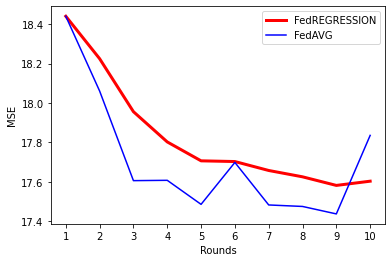

In [164]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(1, num_rounds+1)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(ymin=3, ymax=7)

plt.plot(x, err, color='red', label='FedREGRESSION', linewidth=3)
plt.plot(x, err_s, color='blue', label='FedAVG')
plt.legend(loc='best')

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()

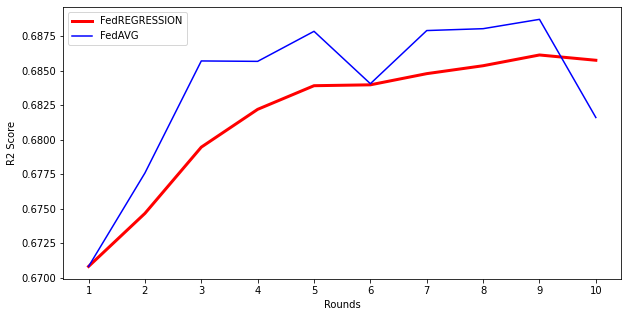

In [165]:
figure(figsize=(10,5))

x = np.arange(1, num_rounds+1)

plt.plot(x, sc, color='red',label='FedREGRESSION', linewidth=3)
plt.plot(x, sc_s, color='blue', label='FedAVG')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(ymin=0.5, ymax=0.8)

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")
plt.legend(loc='best')

plt.draw()

In [ ]:
#plt.figure(figsize=(20,5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Test 0')


x = np.arange(num_rounds)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))


ax1.plot(x, err, color='red', label='FedREGRESSION', linewidth=3)
ax1.plot(x, err_s, color='blue', label='FedAVG')
ax1.legend(loc='best')

ax1.set_xlabel("Rounds")
ax1.set_ylabel("MSE")

ax1.set_ylim(ymin=15, ymax=25)





ax2.plot(x, sc, color='red', label='FedREGRESSION', linewidth=3)
ax2.plot(x, sc_s, color='blue', label='FedAVG')
ax2.legend(loc='best')

ax2.set_xlabel("Rounds")
ax2.set_ylabel("R2 Score")

ax2.set_ylim(ymin=0.55, ymax=0.75)




plt.draw()

plt.savefig("test0.svg")